In [61]:
import skrf as rf
from math import pi
from skrf.media.cpw import CPW
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from modeling.utils.resonators import cpw_cl_ll, resonator_kappa
from modeling.utils.network import assemble_network
from modeling.utils.qubits import e_charge, planck_h, phi0, get_Ic_from_Lj
from qucat import Network,L,J,C
from modeling.smooth_capacitor.libraries.smooth_capacitor_library import digit_tee_ck_to_ground, get_ck
from scipy.optimize import fsolve
from modeling.clockmon.libraries.clockmon_library_2ports import clockmon_cqr_to_ground, clockmon_coupling_libraries

In [62]:
# Crosstalk matrix
# 1 - Lower pad of qb1
# 2 - Upper pad of qb1
# 3 - Lower pad of qb2
# 4 - Upper pad of qb2
C11 = 1.06053733201e-13
C12 = 3.66861355889e-14
C13 = 2.18187498008e-17
C14 = 1.39279875929e-17
C22 = 1.08514488394e-13
C23 = 3.29784355009e-17
C24 = 2.09781223949e-17
C33 = 1.07015490075e-13
C34 = 3.67196762469e-14
C44 = 1.08496195805e-13
cir = Network([
    C(0, 1, C11),
    C(1, 2, C12),
    C(1, 3, C13),
    C(1, 4, C14),
    C(2, 3, C23),
    C(2, 0, C22),
    C(2, 4, C24),
    C(0, 3, C33),
    C(3, 4, C34),
    C(0, 4, C44),

    J(1, 2, 'Lj1'),
    J(3, 4, 'Lj2'),
    ])
Lj1_list = np.linspace(10.03e-9,10.0307e-9,101)
freqs = cir.eigenfrequencies(Lj1=Lj1_list, Lj2 = 10e-9)
g_12 = abs(freqs[0] - freqs[1]).min()/2
print(g_12)

29190.650802612305


In [63]:
a = 10e-6
b = 6e-6
ep_r = 11.45
Z0 = CPW(w = a, s = b, ep_r = ep_r).z0[0].real

rr_freq_target = np.array([7.4e9, 7.2e9])
l_rr = Z0*pi/(4*pi*rr_freq_target)
c_rr = 1/((2*pi*rr_freq_target)**2*l_rr)

cplr_freq_target = np.array(7.0001590796504e9)
l_cr = Z0*pi/(4*pi*cplr_freq_target)
c_cr = 1/((2*pi*cplr_freq_target)**2*l_cr)

c_sigma = 89e-15
chi = 0.4e6
kappa_target = 0.8e6
qubit_freq_target = [4.5e9, 4.4025e9]

g_coupling_target = 80e6
def get_g(EC, Ej, c_coupling, c_r, wr):
    g = EC/ (e_charge) * (Ej/EC/2)**(1/4) * c_coupling / (c_cr) * np.sqrt(2*planck_h * wr * (c_r))
    return g


In [64]:
def minimize_func(x, c_rr = None, l_rr = None, c_cr = None, l_cr = None, qubit_freq_target = None, 
                  g_coupling_target = None, chi = None):
    c_r1 = x[0]*1e-15
    c_r2 = x[1]*1e-15
    c_c1 = x[2]*1e-15
    c_c2 = x[3]*1e-15
    Lj1 = x[4]*1e-9
    Lj2 = x[5]*1e-9

    EC = e_charge**2/(c_sigma)/2/planck_h
    Ic1 = get_Ic_from_Lj(Lj1)
    Ej1 = Ic1*phi0/2/pi/planck_h
    Ic2 = get_Ic_from_Lj(Lj2)
    Ej2 = Ic2*phi0/2/pi/planck_h

    cir = Network([
        C(0,1, c_sigma - c_r1 - c_c1), # transmon 1
        J(0,1, Lj1),
        C(0,2, c_sigma - c_r2 - c_c2), # transmon 2
        J(0,2,Lj2),

        C(0,3, c_rr[0] - c_r1), # readout resonator 1
        L(0,3, l_rr[0]),
        C(0,4, c_rr[1] - c_r2), # readout resonator 2
        L(0,4, l_rr[1]),
        C(0, 5, c_cr - c_c1 - c_c2), # coupling resonator 
        L(0, 5, l_cr),

        C(1, 3, c_r1), # transmon 1 - readout resonator 1
        C(2, 4, c_r2), # transmon 2 - readout resonator 2
        C(1, 5, c_c1), # transmon 1 - coupling resonator
        C(2, 5, c_c2), # transmon 2 - coupling resonator
    ])
    chi1 = cir.kerr()[1, 4]
    chi2 = cir.kerr()[0, 3]
    g1_c = get_g(EC, Ej1, c_c1, c_cr, cplr_freq_target)
    g2_c = get_g(EC, Ej2, c_c2, c_cr, cplr_freq_target)
    
    H = cir.hamiltonian(modes = [0, 1, 2, 3, 4],
                    taylor = 7,
                    excitations = [6, 6, 2, 2, 2])
    eigs = H.eigenenergies().real
    eigs -= eigs[0]
    freq_qb_1 = eigs[2]
    freq_qb_2 = eigs[1]

    err_chi1 = abs((chi1 - chi) / 1e6)
    err_chi2 = abs((chi2 - chi) / 1e6)
    err_g1 = abs((g1_c - g_coupling_target) / 1e9)
    err_g2 = abs((g2_c - g_coupling_target) / 1e9)
    err_freq1 = abs((freq_qb_1 - qubit_freq_target[0]) / 1e9)
    err_freq2 = abs((freq_qb_2 - qubit_freq_target[1]) / 1e9)
    return err_chi1, err_chi2, err_g1, err_g2, err_freq1, err_freq2


In [65]:
lower_bounds = [0, 0, 0, 0, 10, 11]
upper_bounds = [6, 6, 9, 9, 16, 17]
solution = fsolve(minimize_func, [3, 3, 3, 3, 14, 15], args =(c_rr, l_rr, c_cr, l_cr, qubit_freq_target, g_coupling_target, chi),
                         )

In [66]:
c_r1, c_r2, c_c1, c_c2, Lj1, Lj2 = solution*np.array([1e-15, 1e-15, 1e-15, 1e-15, 1e-9, 1e-9])

In [67]:
x = solution

c_r1 = x[0]*1e-15
c_r2 = x[1]*1e-15
c_c1 = x[2]*1e-15
c_c2 = x[3]*1e-15
Lj1 = x[4]*1e-9
Lj2 = x[5]*1e-9

EC = e_charge**2/(c_sigma)/2/planck_h
Ic1 = get_Ic_from_Lj(Lj1)
Ej1 = Ic1*phi0/2/pi/planck_h
Ic2 = get_Ic_from_Lj(Lj2)
Ej2 = Ic2*phi0/2/pi/planck_h

cir = Network([
    C(0,1, c_sigma - c_r1 - c_c1), # transmon 1
    J(0,1, Lj1),
    C(0,2, c_sigma - c_r2 - c_c2), # transmon 2
    J(0,2, Lj2),

    C(0,3, c_rr[0] - c_r1), # readout resonator 1
    L(0,3, l_rr[0]),
    C(0,4, c_rr[1] - c_r2), # readout resonator 2
    L(0,4, l_rr[1]),
    C(0, 5, c_cr - c_c1 - c_c2), # coupling resonator 
    L(0, 5, l_cr),

    C(1, 3, c_r1), # transmon 1 - readout resonator 1
    C(2, 4, c_r2), # transmon 2 - readout resonator 2
    C(1, 5, c_c1), # transmon 1 - coupling resonator
    C(2, 5, c_c2), # transmon 2 - coupling resonator
])

In [68]:
_ = cir.f_k_A_chi(pretty_print=True)

         mode |       freq.  |       diss.  |       anha.  |
            0 |     4.63 GHz |          0Hz |      217 MHz |
            1 |     4.73 GHz |          0Hz |      217 MHz |
            2 |     7.01 GHz |          0Hz |     1.21 kHz |
            3 |      7.2 GHz |          0Hz |       185 Hz |
            4 |      7.4 GHz |          0Hz |       185 Hz |

Kerr coefficients (diagonal = Kerr, off-diagonal = cross-Kerr)
         mode |         0    |         1    |         2    |         3    |         4    |
            0 |      217 MHz |              |              |              |              |
            1 |      199 kHz |      217 MHz |              |              |              |
            2 |      693 kHz |      752 kHz |     1.21 kHz |              |              |
            3 |      400 kHz |       355 Hz |       640 Hz |       185 Hz |              |
            4 |       144 Hz |      400 kHz |       694 Hz |      291 mHz |       185 Hz |



In [69]:
def minimize_for_ck(x, resonator_frequency):
    k = resonator_kappa(resonator_frequency, x[0]*1e-15, Z0)/ 2/ pi / np.sqrt(2)
    return abs(k - kappa_target)

cks = np.zeros((2))
for i in range(2):
    cks[i] = fsolve(minimize_for_ck, 5, args = (rr_freq_target[i]))[0]*1e-15

In [70]:
qb1_lib = clockmon_coupling_libraries(port_id = "0_2")
qb2_lib = clockmon_coupling_libraries(port_id = "0_3")
ck_given_coupling = get_ck()

qb1_coupler_widths = qb1_lib(c_r1, c_c1)
qb2_coupler_widths = qb2_lib(c_r2, c_c2)
finger_control = ck_given_coupling(cks)

print(f"Coupler 0 width for qubit 1: {qb1_coupler_widths[0]:.5} um")
print(f"Coupler 2 width for qubit 1: {qb1_coupler_widths[1]:.5} um")
print(f"Coupler 0 width for qubit 2: {qb2_coupler_widths[0]:.5} um")
print(f"Coupler 3 width for qubit 2: {qb1_coupler_widths[1]:.5} um")
print(f"Finger control for qubit 1: {finger_control[0]:.5}")
print(f"Finger control for qubit 2: {finger_control[1]:.5}")

Coupler 0 width for qubit 1: 96.336 um
Coupler 2 width for qubit 1: 168.62 um
Coupler 0 width for qubit 2: 94.406 um
Coupler 3 width for qubit 2: 168.62 um
Finger control for qubit 1: 1.9291
Finger control for qubit 2: 1.9618


In [71]:
cr1_to_ground = clockmon_cqr_to_ground(port_id = "0_2", ground_id = 0)
cc1_to_ground = clockmon_cqr_to_ground(port_id = "0_2", ground_id = 1)

cr2_to_ground = clockmon_cqr_to_ground(port_id = "0_3", ground_id = 0)
cc2_to_ground = clockmon_cqr_to_ground(port_id = "0_3", ground_id = 1)
ck_to_ground = digit_tee_ck_to_ground(deembed=[300, 200])


In [131]:
# Readout resonators (lambda/4)
rr_cap_to_ground = np.array([cr1_to_ground((c_r1, c_c1)), cr2_to_ground((c_r2, c_c2))])
digit_cap_inductance = 0*1.6210000000000005e-11 # Simulate this
tee_cap_inductance = 0*3.1509999999999996e-11 # Simulate this
c_l, l_l = cpw_cl_ll(a, b, ep_r)
v_ph = 1/np.sqrt(c_l*l_l)
unloaded_wg_lengths = v_ph / rr_freq_target / 2
l_r_loaded = 1/2 * Z0 * np.sqrt((unloaded_wg_lengths*c_l)*
                                (unloaded_wg_lengths*l_l - digit_cap_inductance - tee_cap_inductance))
c_r_loaded = 2/(np.pi**2 * Z0)*np.sqrt((unloaded_wg_lengths*c_l - rr_cap_to_ground - ck_to_ground(cks))*
                                (unloaded_wg_lengths*l_l))
c_r_loaded -= [c_r1, c_r2]
c_r_loaded -= cks
rr_waveguide_lengths = np.pi * np.sqrt((c_r_loaded * l_r_loaded) / (c_l*l_l)) / 2
rr_waveguide_lengths

array([0.00389898, 0.00400807])

In [126]:
# Readout resonators (lambda/4)
rr_cap_to_ground = np.array([cr1_to_ground((c_r1, c_c1)), cr2_to_ground((c_r2, c_c2))])
digit_cap_inductance = 0*1.6210000000000005e-11 # Simulate this
tee_cap_inductance = 0*3.1509999999999996e-11 # Simulate this
c_l, l_l = cpw_cl_ll(a, b, ep_r)
v_ph = 1/np.sqrt(c_l*l_l)
unloaded_wg_lengths = v_ph / rr_freq_target / 2
l_r_loaded = 1/2 * Z0 * np.sqrt((unloaded_wg_lengths*c_l)*
                                (unloaded_wg_lengths*l_l - digit_cap_inductance - tee_cap_inductance))
c_r_loaded = 2/(np.pi**2 * Z0)*np.sqrt((unloaded_wg_lengths*c_l - rr_cap_to_ground - ck_to_ground(cks))*
                                (unloaded_wg_lengths*l_l))
c_r_loaded -= [c_r1, c_r2]
c_r_loaded -= cks
rr_waveguide_lengths = np.pi * np.sqrt((c_r_loaded * l_r_loaded) / (c_l*l_l)) / 2
rr_waveguide_lengths

array([0.00393652, 0.0040465 ])

In [86]:
# Coupler (lambda/2)
digit_cap_inductance = 1.6210000000000005e-11 # Simulate this
tee_cap_inductance = 3.1509999999999996e-11 # Simulate this
c_l, l_l = cpw_cl_ll(a, b, ep_r)
v_ph = 1/np.sqrt(c_l*l_l)
unloaded_wg_length = v_ph / cplr_freq_target / 2
l_r_loaded = 1/2 * Z0 * np.sqrt((unloaded_wg_length*c_l - cc1_to_ground((c_r1, c_c1)) - cc2_to_ground((c_r1, c_c2)))*
                                (unloaded_wg_length*l_l - digit_cap_inductance - tee_cap_inductance))
c_r_loaded = 2/(np.pi**2 * Z0)*np.sqrt((unloaded_wg_length*c_l - cc1_to_ground((c_r1, c_c1)) - cc2_to_ground((c_r1, c_c2)))*
                                (unloaded_wg_length*l_l - digit_cap_inductance - tee_cap_inductance))
c_r_loaded -= (c_c1 + c_c2)
cplr_waveguide_lengths = np.pi * np.sqrt((c_r_loaded * l_r_loaded) / (c_l*l_l))
cplr_waveguide_lengths

0.008188899799763432

In [74]:
fl_traits = pd.read_csv("two_clockmons_00.csv").values[0][1:]
transmission_line_tee_points = []
transmission_line_tee_points += [float(fl_traits[0]) + (a+2*b)/2*1e6]
transmission_line_tee_points += [fl_traits[1] + (a+2*b)*1e6]
transmission_line_tee_points += [fl_traits[2] + (a+2*b)/2*1e6]
options = {
    "qubit_c": np.array([c_sigma]*2),
    "qubit_l": np.array([Lj1, Lj2]),
    "readout_resonator_c": c_rr - np.array([c_r1, c_r2]) - cks,
    "readout_resonator_l": l_rr,
    "ck": cks,
    "cqr": np.array([c_r1, c_r2]),
    "feedline_traits": transmission_line_tee_points,
    "frequency": [7.19, 7.21],
    "n_points": 501,
    "type": "simple"
}

2-Port Network: '',  7.19-7.21 GHz, 501 pts, z0=[50.+0.j 50.+0.j]


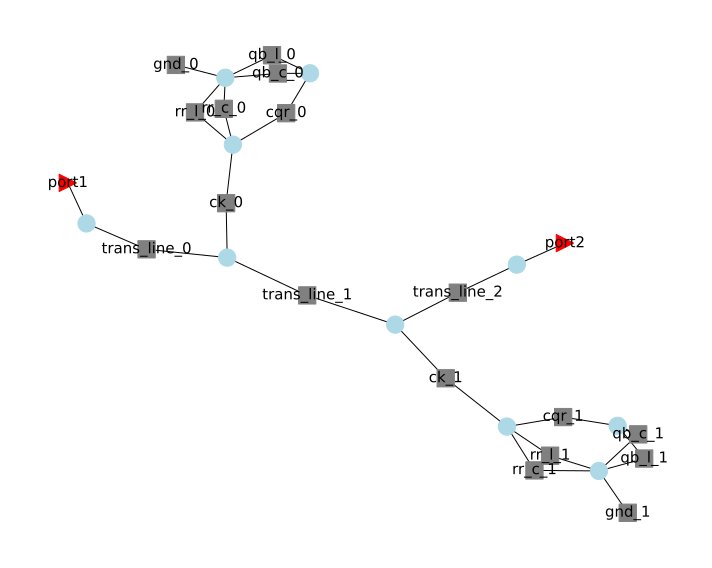

In [75]:
cnx = assemble_network(options)
cir = rf.Circuit(cnx)

cir.plot_graph(network_labels=True, network_fontsize=15,
               port_labels=True, port_fontsize=15,
               edge_fontsize=10)

# Get the resulting Network from the 'network' parameter:
ntw = cir.network
print(ntw)

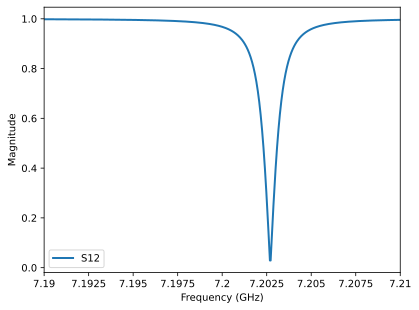

In [76]:
ntw.plot_s_mag(m=0, n=1, lw=2)


# scikit-rf check for loaded waveguide length correction

In [127]:
freq = rf.Frequency(start=7.35, stop=7.45, unit='GHz', npoints=1001)
capacitor = rf.DefinedGammaZ0(freq, z0=50).capacitor
inductor = rf.DefinedGammaZ0(freq, z0=50).inductor
cpw = CPW(frequency = freq, w = 10e-6, s = 6e-6, ep_r = ep_r)
port1 = rf.Circuit.Port(freq, 'port1', z0=50) # Launcher 1
port2 = rf.Circuit.Port(freq, 'port2', z0=50) # Launcher 2
port3 = rf.Circuit.Port(freq, 'port3', z0=50) # Launcher 2
gnd1 = rf.Circuit.Ground(freq, name='gnd1')
gnd2 = rf.Circuit.Ground(freq, name='gnd2')
gnd3 = rf.Circuit.Ground(freq, name='gnd3')
gnd4 = rf.Circuit.Ground(freq, name='gnd4')


tl_in = cpw.line(d = 5/1e6, unit='m', name='trans_line_in')
tl_out = cpw.line(d = 5/1e6, unit='m', name='trans_line_out')
cap = capacitor(cks[0], name='ck')
ground_cap = capacitor(ck_to_ground(cks[0]), name = 'ckg')
ground_ind_cap = inductor(digit_cap_inductance, name = "lkg")

cqr = capacitor(c_r1, name='cqr')
ground_cqr = capacitor(cr1_to_ground((c_r1, c_c1)), name = 'cqrg')
ground_lqr = inductor(tee_cap_inductance, name = "lqr")

qubit_c = capacitor(90e-15, name='cs')
qubit_l = inductor(14e-9, name = 'lj')

wg1_len, wg2_len, wg3_len = (306.8 + 11)/1e6, (958.416 + 31)/1e6, (366.473 + 11)/1e6
wg1 = cpw.line(d = wg1_len, unit='m', name='wg1') # corrected to take into account the tee
wg2 = cpw.line(d = wg2_len, unit='m', name='wg2')
wg3 = cpw.line(d = wg3_len, unit='m', name='wg3')

meander_length = rr_waveguide_lengths[0]- wg1_len - wg2_len - wg3_len
meander = cpw.line(d = meander_length, unit='m', name='meander')



 c:\Users\moret\Desktop\work\.venv\Lib\site-packages\skrf\media\media.py: 723RuntimeWarning: invalid value encountered in divide
 c:\Users\moret\Desktop\work\.venv\Lib\site-packages\skrf\media\media.py: 723RuntimeWarning: divide by zero encountered in divide
 c:\Users\moret\Desktop\work\.venv\Lib\site-packages\skrf\media\media.py: 724RuntimeWarning: invalid value encountered in divide
 c:\Users\moret\Desktop\work\.venv\Lib\site-packages\skrf\media\media.py: 724RuntimeWarning: divide by zero encountered in divide
 c:\Users\moret\Desktop\work\.venv\Lib\site-packages\skrf\media\media.py: 725RuntimeWarning: invalid value encountered in divide
 c:\Users\moret\Desktop\work\.venv\Lib\site-packages\skrf\media\media.py: 725RuntimeWarning: divide by zero encountered in divide
 c:\Users\moret\Desktop\work\.venv\Lib\site-packages\skrf\media\media.py: 726RuntimeWarning: invalid value encountered in divide
 c:\Users\moret\Desktop\work\.venv\Lib\site-packages\skrf\media\media.py: 726RuntimeWarning: i

In [128]:
# cnx = [ [(port1, 0), (tl_in, 0)],
#     [(tl_in, 1), (tl_out, 0), (cap, 0)],
#     [(tl_out, 1), (port2, 0)],
#     [(ground_ind_cap, 0), (cap, 1), (ground_cap, 0)],
#     [(ground_ind_cap, 1), (wg1, 0)],
#     [(ground_cap, 1), (gnd3, 0)],
#     [(wg1, 1), (wg2, 0), (wg3, 0)],
#     [(wg3, 1), (meander, 0)],
#     [(meander, 1), (gnd1, 0)],
#     [(ground_lqr, 0), (cqr, 0), (ground_cqr, 0)],
#     [(ground_lqr, 1), (wg2, 1)],
#     [(ground_cqr, 1), (gnd4, 0)],
#     [(cqr, 1), (qubit_c, 0), (qubit_l, 0)],
#     [(qubit_c, 1), (qubit_l, 1), (gnd2, 0)]
# ]

cnx = [ [(port1, 0), (tl_in, 0)],
    [(tl_in, 1), (tl_out, 0), (cap, 0)],
    [(tl_out, 1), (port2, 0)],
    [(wg1, 0), (cap, 1), (ground_cap, 0)],
    [(ground_cap, 1), (gnd3, 0)],
    [(wg1, 1), (wg2, 0), (wg3, 0)],
    [(wg3, 1), (meander, 0)],
    [(meander, 1), (gnd1, 0)],
    [(wg2, 1), (cqr, 0), (ground_cqr, 0)],
    [(ground_cqr, 1), (gnd4, 0)],
    [(cqr, 1), (qubit_c, 0), (qubit_l, 0)],
    [(qubit_c, 1), (qubit_l, 1), (gnd2, 0)]
]

# cnx = [ [(port1, 0), (tl_in, 0)],
#     [(tl_in, 1), (tl_out, 0), (cap, 0)],
#     [(tl_out, 1), (port2, 0)],
#     [(wg1, 0), (cap, 1)],
#     [(wg1, 1), (wg2, 0), (wg3, 0)],
#     [(wg3, 1), (meander, 0)],
#     [(meander, 1), (gnd1, 0)],
#     [(wg2, 1), (cqr, 0)],
#     [(cqr, 1), (qubit_c, 0), (qubit_l, 0)],
#     [(qubit_c, 1), (qubit_l, 1), (gnd2, 0)]
# ]

2-Port Network: '',  7.35-7.45 GHz, 1001 pts, z0=[50.+0.j 50.+0.j]


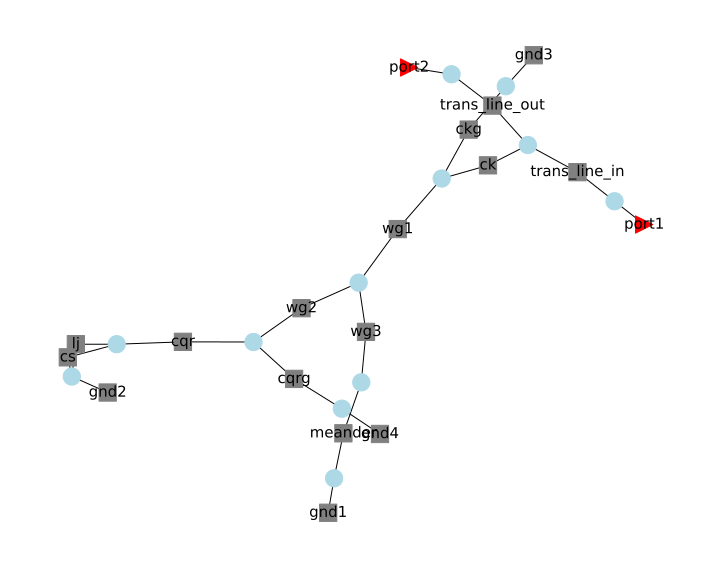

In [129]:
cir = rf.Circuit(cnx)

cir.plot_graph(network_labels=True, network_fontsize=15,
               port_labels=True, port_fontsize=15,
               edge_fontsize=10)

# Get the resulting Network from the 'network' parameter:
ntw = cir.network
print(ntw)

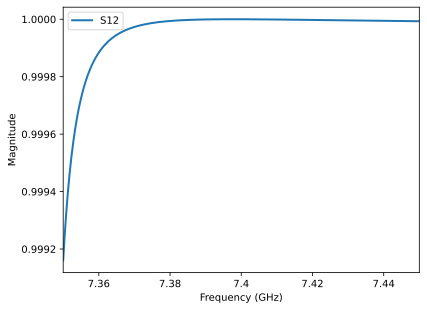

In [130]:
ntw.plot_s_mag(m=0, n=1, lw=2)
